In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway


df_integrated = pd.read_csv("run1/alldf_integrated.csv")
print(" File read done")
# ---------------------------
# 1️⃣ Prepare data
# ---------------------------
# Remove unwanted columns (if read from CSV)
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)

# Numeric features
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]

# ---------------------------
# 2️⃣ Compute p-values across timepoints (ANOVA)
# ---------------------------
p_values = {}
timepoints = df_integrated['Timepoint'].unique()
for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

 File read done


In [2]:
# Rank by statistical significance (ANOVA / p-value)
# Sort features by p-value
top_features = p_values.sort_values().head(10)  # top 10 most significant features
print(top_features)

CCL23            0.000002
CCL7             0.000002
ADAM12           0.000004
CALCA            0.000006
BMP7             0.000062
NEUT%(%)         0.000094
LYMPH%(%)        0.000133
C16orf89         0.000142
NEUT#(10^9/L)    0.000177
CD70             0.000187
dtype: float64


In [3]:
# Rank by variance / variability
feature_variance = df_integrated.iloc[:, 2:].var()  # exclude PatientID, Timepoint
top_variance_features = feature_variance.sort_values(ascending=False).head(10)
print(top_variance_features)


IG#(10^9/L)      1.765907
HCT(L/L)         1.375772
BASO%(%)         1.371143
RBC(10^12/L)     1.370659
HGB(g/L)         1.255258
MONO#(10^9/L)    1.230043
EO%(%)           1.228461
CD160            1.071429
AP3B1            1.071428
ATP6V1F          1.071427
dtype: float64


In [8]:
import pandas as pd
from scipy.stats import f_oneway

# ---------------------------
# 1️⃣ Compute ANOVA p-values across timepoints
# ---------------------------
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]
p_values = {}
timepoints = df_integrated['Timepoint'].unique()

for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

# Select significant features (p < 0.05)
sig_features = p_values[p_values < 0.05].index.tolist()
print("Significant features:", sig_features)

# ---------------------------
# 2️⃣ Compute feature variance
# ---------------------------
feature_variance = df_integrated[numeric_cols].var()

# ---------------------------
# 3️⃣ Optional: correlation with blood markers (mean absolute correlation)
# ---------------------------
# Assuming blood features are columns 2:15
blood_features = df_integrated.columns[2:15]
protein_features = df_integrated.columns[15:]

blood_data = df_integrated[blood_features].apply(pd.to_numeric, errors='coerce')
protein_data = df_integrated[protein_features].apply(pd.to_numeric, errors='coerce')

# Compute mean absolute correlation for each protein with all blood markers
mean_corr = protein_data.apply(lambda x: blood_data.corrwith(x).abs().mean(), axis=0)

# ---------------------------
# 4️⃣ Compute composite score
# ---------------------------
# Using ANOVA p-value, variance, and mean correlation (only for significant features)
score = (
    (1 / p_values[sig_features]) +                   # smaller p = higher score
    feature_variance[sig_features].rank()            # higher variance = higher rank
)


# Sort features by composite score
top_features_final = score.sort_values(ascending=False).head(10)
print("Top 10 features based on composite score:\n", top_features_final)


Significant features: ['WBC(10^9/L)', 'NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'IG#(10^9/L)', 'ABI3BP', 'ACAN', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAMTS15', 'ADGRB1', 'ADGRE1', 'ADGRE3', 'ADM', 'AHNAK2', 'ALPI', 'AMIGO2', 'APBB1IP', 'ASGR1', 'ATAD3B', 'ATP6AP2', 'ATRAID', 'BACE1', 'BMP4', 'BMP7', 'BOC', 'BSG', 'C16orf89', 'C1QTNF6', 'C8orf34', 'CA12', 'CA14', 'CALCA', 'CAPN3', 'CCL20', 'CCL23', 'CCL25', 'CCL7', 'CCN1', 'CCN4', 'CD200', 'CD207', 'CD244', 'CD28', 'CD300LB', 'CD302', 'CD4', 'CD6', 'CD70', 'CD83', 'CDCP1', 'CEACAM8', 'CEBPA', 'CEBPB', 'CEMIP2', 'CHCHD6', 'CKAP4', 'CLEC10A', 'CLEC4C', 'CLEC4D', 'CLSTN3']
Top 10 features based on composite score:
 CCL23            521676.347967
CCL7             518272.575333
ADAM12           255313.986294
CALCA            170690.700227
BMP7              16234.007468
NEUT%(%)          10632.135891
LYMPH%(%)          7503.441146
C16orf89           7030.981650
NEUT#(10^9/L)      5673.362440
CD7

In [10]:
mean_corr_all = pd.Series(0, index=sig_features)
for f in sig_features:
    if f in mean_corr.index:
        mean_corr_all[f] = mean_corr[f]

# ---------------------------
# 5️⃣ Compute composite score
# ---------------------------
score = (
    (1 / p_values[sig_features]) +            # smaller p = higher score
    feature_variance[sig_features].rank() +   # higher variance = higher rank
    mean_corr_all.rank()                       # higher correlation = higher rank
)


feature_table = pd.DataFrame({
    'ANOVA_pval': p_values[sig_features],
    'Variance': feature_variance[sig_features],
    'MeanCorr': mean_corr_all,
    'CompositeScore': score
})

feature_table = feature_table.sort_values('CompositeScore', ascending=False)
feature_table['Rank'] = range(1, len(feature_table)+1)

# Display top 10 features
print(feature_table.head(10))

               ANOVA_pval  Variance  MeanCorr  CompositeScore  Rank
CCL23            0.000002  1.050429  0.439133   521740.347967     1
CCL7             0.000002  1.047545  0.405160   518335.575333     2
ADAM12           0.000004  1.068461  0.289296   255353.986294     3
CALCA            0.000006  1.071361  0.476549   170756.700227     4
BMP7             0.000062  1.064616  0.392801    16293.007468     5
NEUT%(%)         0.000094  0.829482  0.000000    10636.635891     6
LYMPH%(%)        0.000133  0.653972  0.000000     7507.941146     7
C16orf89         0.000142  1.002121  0.403371     7092.981650     8
NEUT#(10^9/L)    0.000177  1.041005  0.000000     5677.862440     9
CD70             0.000187  1.071206  0.268977     5442.683441    10


C:\Users\mondalsy\AppData\Local\Temp\ipykernel_19980\2387018262.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.34410834458299' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_corr_all[f] = mean_corr[f]


<Figure size 1200x800 with 0 Axes>

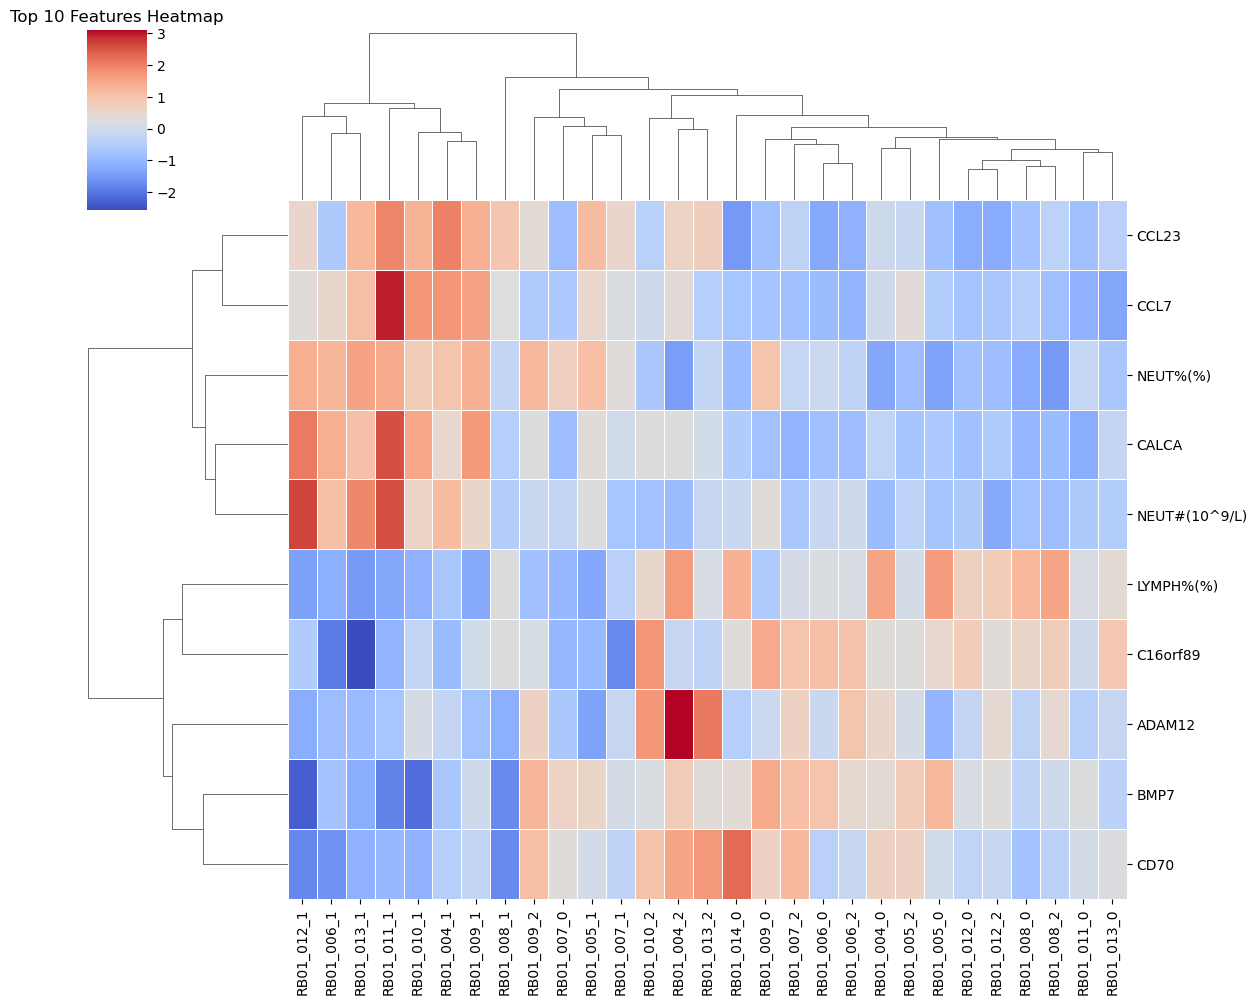

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------------------------
# Select top N features
# ---------------------------
top_n = 10
top_features = feature_table.head(top_n).index.tolist()

# Subset the data
data_top = df_integrated[top_features].copy()

# Scale features for heatmap
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_top)
data_scaled = pd.DataFrame(data_scaled, columns=top_features, index=df_integrated['PatientID'] + "_" + df_integrated['Timepoint'].astype(str))

# ---------------------------
# Plot clustered heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
sns.clustermap(
    data_scaled.T,       # features as rows, samples as columns
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    figsize=(12, 10)
)
plt.title(f"Top {top_n} Features Heatmap")
plt.show()
